In [1]:
import sys
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras 
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import load_model
from sklearn.metrics import roc_curve
from sklearn.metrics import auc
import math
import tqdm
from PyPDF2 import PdfMerger
import os
from os import listdir
from os.path import isfile, join

2023-05-02 10:55:40.262320: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-05-02 10:55:41.118809: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
wireplane = 'U'

In [3]:
x_test_old = np.load('./Neutrino-Trained/processed_data/x_test_' + wireplane + '.npy')
y_test_old = np.load('./Neutrino-Trained/processed_data/y_test_AE_' + wireplane + '.npy')


mean_old = np.load('./Neutrino-Trained/AutoEncoder/results/'+wireplane+'/models/mean_AE_'+wireplane+'.npy')
std_old = np.load('./Neutrino-Trained/AutoEncoder/results/'+wireplane+'/models/std_AE_'+wireplane+'.npy')

x_test_scaled_old = (x_test_old-mean_old)/std_old
y_test_scaled_old = (y_test_old-mean_old)/std_old

In [4]:
x_test_new = np.load('./Neutrino-Trained-New-Dataset/processed_data/x_test_' + wireplane + '.npy')
y_test_new = np.load('./Neutrino-Trained-New-Dataset/processed_data/y_test_AE_' + wireplane + '.npy')


mean_new = np.load('./Neutrino-Trained-New-Dataset/AutoEncoder-Custom-Loss/results/'+wireplane+'/models/mean_AE_'+wireplane+'.npy')
std_new = np.load('./Neutrino-Trained-New-Dataset/AutoEncoder-Custom-Loss/results/'+wireplane+'/models/std_AE_'+wireplane+'.npy')

x_test_scaled_new = (x_test_new-mean_new)/std_new
y_test_scaled_new = (y_test_new-mean_new)/std_new

In [5]:
def custom_mse2(y_true, y_pred):

    return -1

In [6]:
ae128_old = load_model('./Neutrino-Trained/AutoEncoder/results/' + wireplane + '/models/batch_size128_CHECK_' + wireplane + 'plane_nu.h5', custom_objects={'custom_mse2':custom_mse2})
ae128_new = load_model('./Neutrino-Trained-New-Dataset/AutoEncoder-Custom-Loss/results/' + wireplane + '/models/batch_size128_' + wireplane + 'plane_nu.h5', custom_objects={'custom_mse2':custom_mse2})

2023-05-02 10:55:58.896394: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:982] could not open file to read NUMA node: /sys/bus/pci/devices/0000:09:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-05-02 10:55:58.933148: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:982] could not open file to read NUMA node: /sys/bus/pci/devices/0000:09:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-05-02 10:55:58.933211: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:982] could not open file to read NUMA node: /sys/bus/pci/devices/0000:09:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-05-02 10:55:58.936336: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:982] could not open file to read NUMA node: /sys/bus/pci/devices/0000:09:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-05-02 10:55:58.936392: I tensorflow/compile

In [7]:
pred_old_old = ae128_old.predict(x_test_scaled_old, batch_size=4096)
pred_old_old = pred_old_old.reshape(pred_old_old.shape[0], pred_old_old.shape[1])

pred_old_new = ae128_old.predict(x_test_scaled_new, batch_size=4096)
pred_old_new = pred_old_new.reshape(pred_old_new.shape[0], pred_old_new.shape[1])

pred_new_new = ae128_new.predict(x_test_scaled_new, batch_size=4096)
pred_new_new = pred_new_new.reshape(pred_new_new.shape[0], pred_new_new.shape[1])

pred_new_old = ae128_new.predict(x_test_scaled_old, batch_size=4096)
pred_new_old = pred_new_old.reshape(pred_new_old.shape[0], pred_new_old.shape[1])


2023-05-02 10:56:02.303644: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:424] Loaded cuDNN version 8600
2023-05-02 10:56:03.095765: I tensorflow/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory


25/25 [==============================] - 0s 3ms/step


In [8]:
from scipy import stats
x_testold_ = std_old*x_test_scaled_old+mean_old
y_testold_ = y_test_scaled_old*std_old + mean_old

x_testnew_ = std_new*x_test_scaled_new+mean_new
y_testnew_ = y_test_scaled_new*std_new + mean_new


pred_oo = pred_old_old*std_old + mean_old
pred_on = pred_old_new*std_new + mean_new

pred_nn = pred_new_new*std_new + mean_new
pred_no = pred_new_old*std_old + mean_old

#pred1024 = predictions1024*std + mean

In [16]:
y_new_noise_truth = []
y_new_noise_nn = []
y_new_noise_on = []

y_new_sig_truth = []
y_new_sig_pred_nn = []
y_new_sig_pred_on = []

for idx in range(len(y_test_new)):
    if sum(abs(y_test_new[idx])) == 0:
        y_new_noise_truth.append(y_testnew_[idx])
        y_new_noise_nn.append(pred_nn[idx])
        y_new_noise_on.append(pred_on[idx])
    else:
        y_new_sig_truth.append(y_testnew_[idx])
        y_new_sig_pred_nn.append(pred_nn[idx])
        y_new_sig_pred_on.append(pred_on[idx])

In [17]:
y_old_noise_truth = []
y_old_noise_oo = []
y_old_noise_no = []

y_old_sig_truth = []
y_old_sig_pred_oo = []
y_old_sig_pred_no = []

for idx in range(len(y_test_old)):
    if sum(abs(y_test_new[idx])) == 0:
        y_old_noise_truth.append(y_testnew_[idx])
        y_old_noise_oo.append(pred_oo[idx])
        y_old_noise_no.append(pred_no[idx])
    else:
        y_old_sig_truth.append(y_testnew_[idx])
        y_old_sig_pred_oo.append(pred_oo[idx])
        y_old_sig_pred_no.append(pred_no[idx])

In [19]:
len(y_new_noise_truth) + len(y_new_sig_truth)

100000

In [ ]:
len(y_new_noise_oo) + len(y_new_sig_truth)

In [20]:
len(y_old_noise_truth) + len(y_old_sig_truth)

100000

In [ ]:
for i in range(10):
    fig, axs = plt.subplots(2, 2, figsize=(15,8))
    axs[0, 0].plot(y_old_noise_truth[i], color = 'blue')
    axs[0, 0].plot(y_old_noise_oo[i], color = 'm')
    axs[0, 0].set_title('trained on old : test on old')


    axs[0, 1].plot(y_new_noise_truth[i], color = 'blue')
    axs[0, 1].plot(y_new_noise_on[i], color = 'm')
    axs[0, 1].set_title('trained on old : test on new')


    axs[1, 0].plot(y_new_noise_truth[i], color = 'blue')
    axs[1, 0].plot(y_new_noise_nn[i], color = 'm')
    axs[1, 0].set_title('trained on new : test on new')


    axs[1, 1].plot(y_old_noise_truth[i], color = 'blue')
    axs[1, 1].plot(y_old_noise_no[i], color = 'm')
    axs[1, 1].set_title('trained on new : test on old')

    for ax in axs.flat:
        ax.set(xlabel='time', ylabel='adc')

    # Hide x labels and tick labels for top plots and y ticks for right plots.
    for ax in axs.flat:
        ax.label_outer()

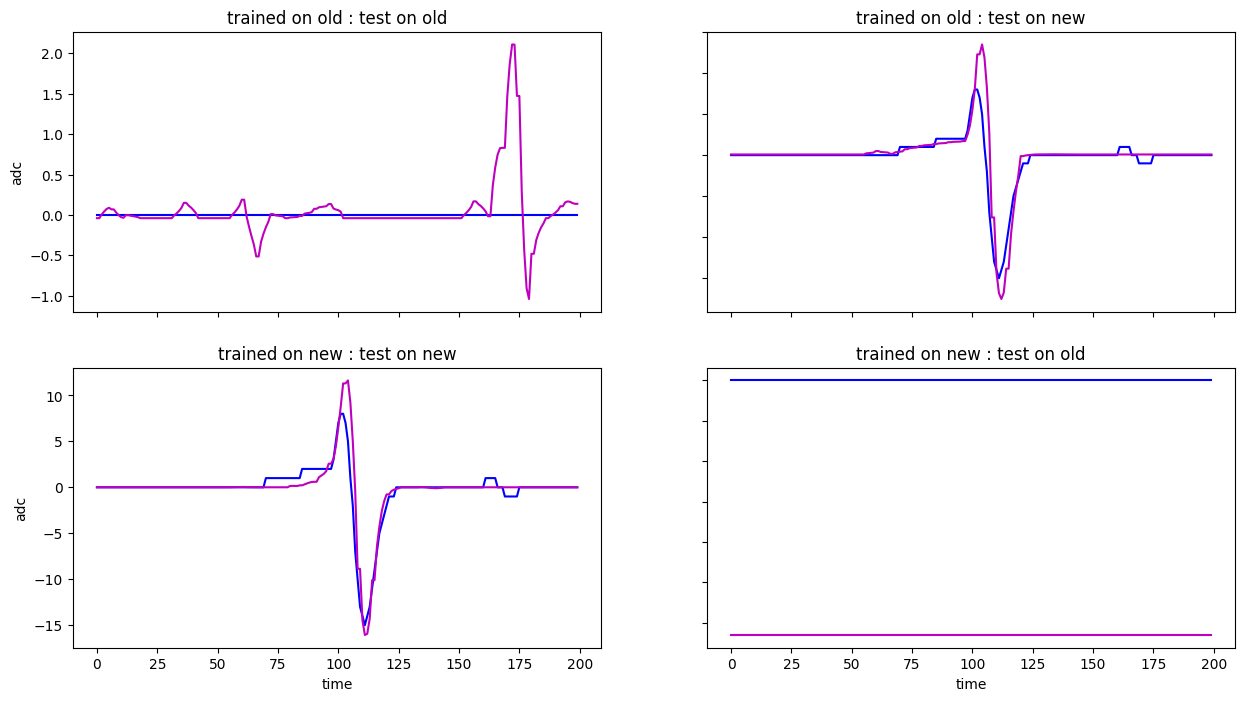

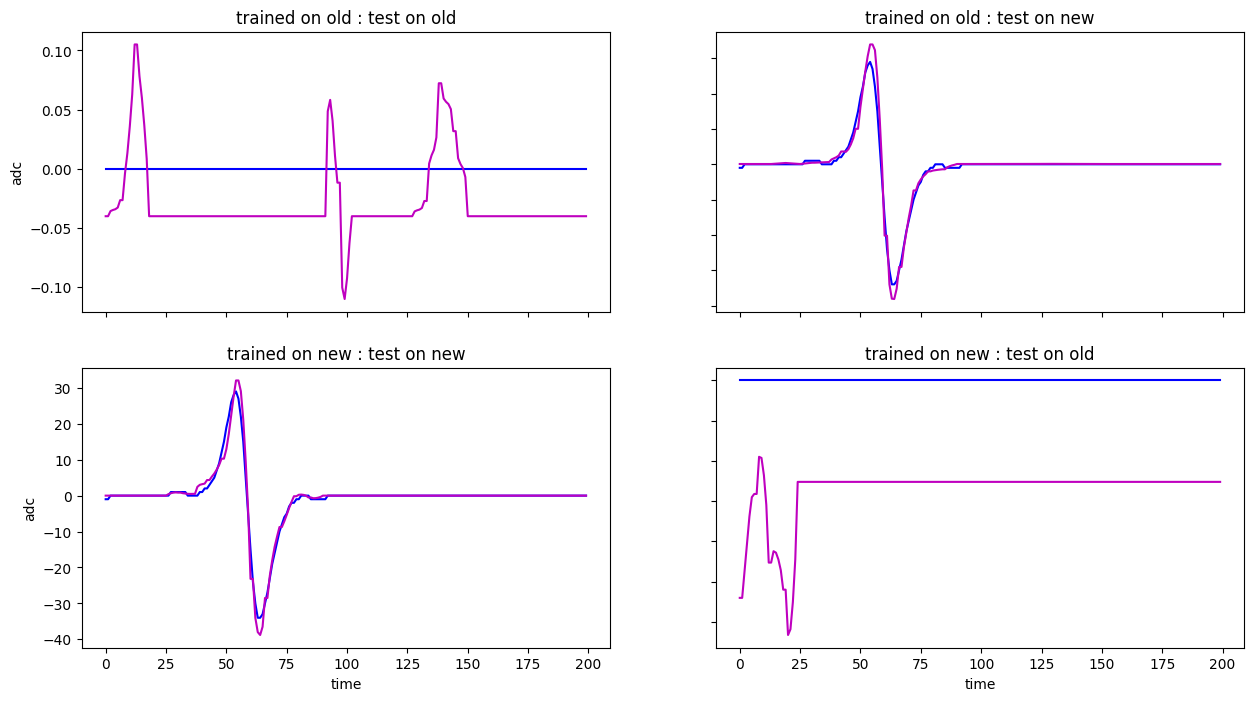

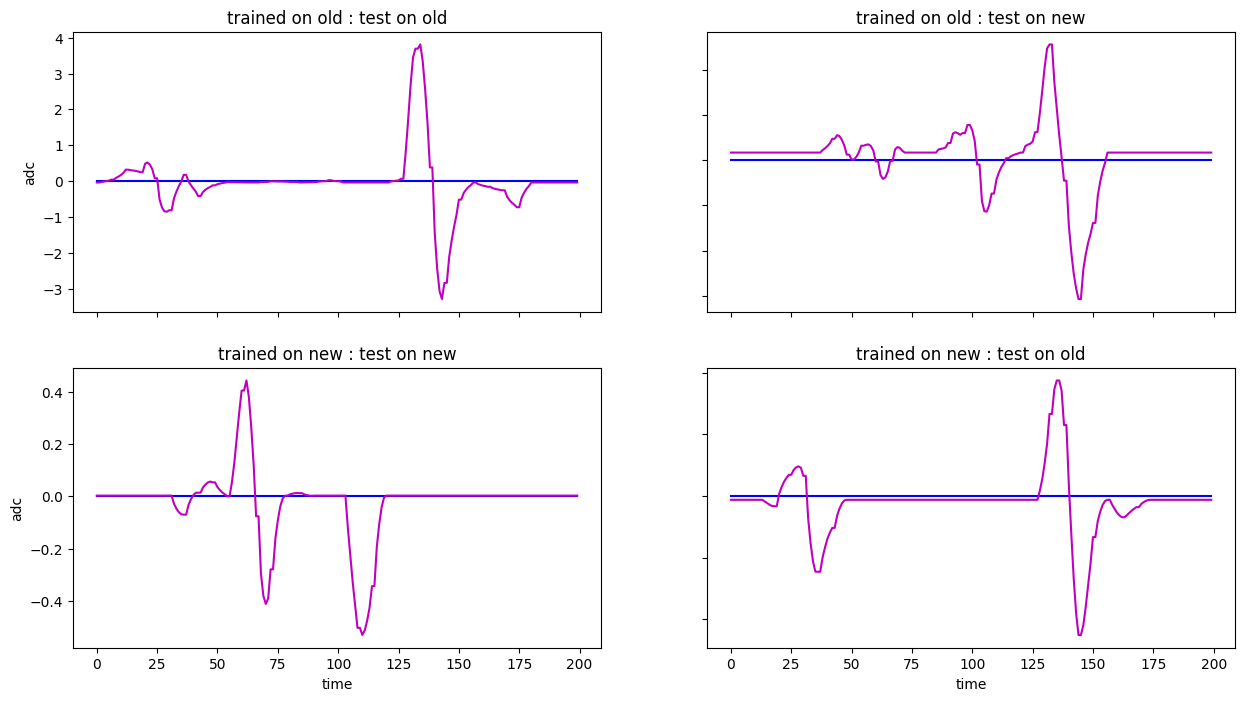

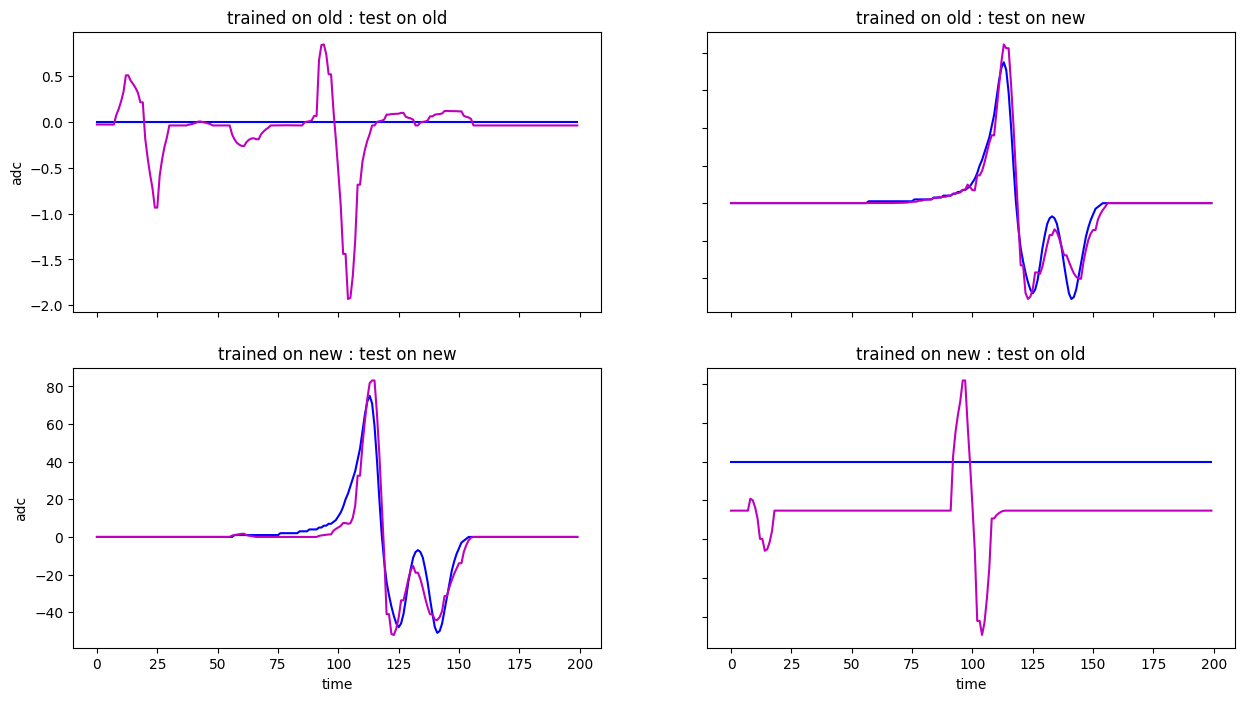

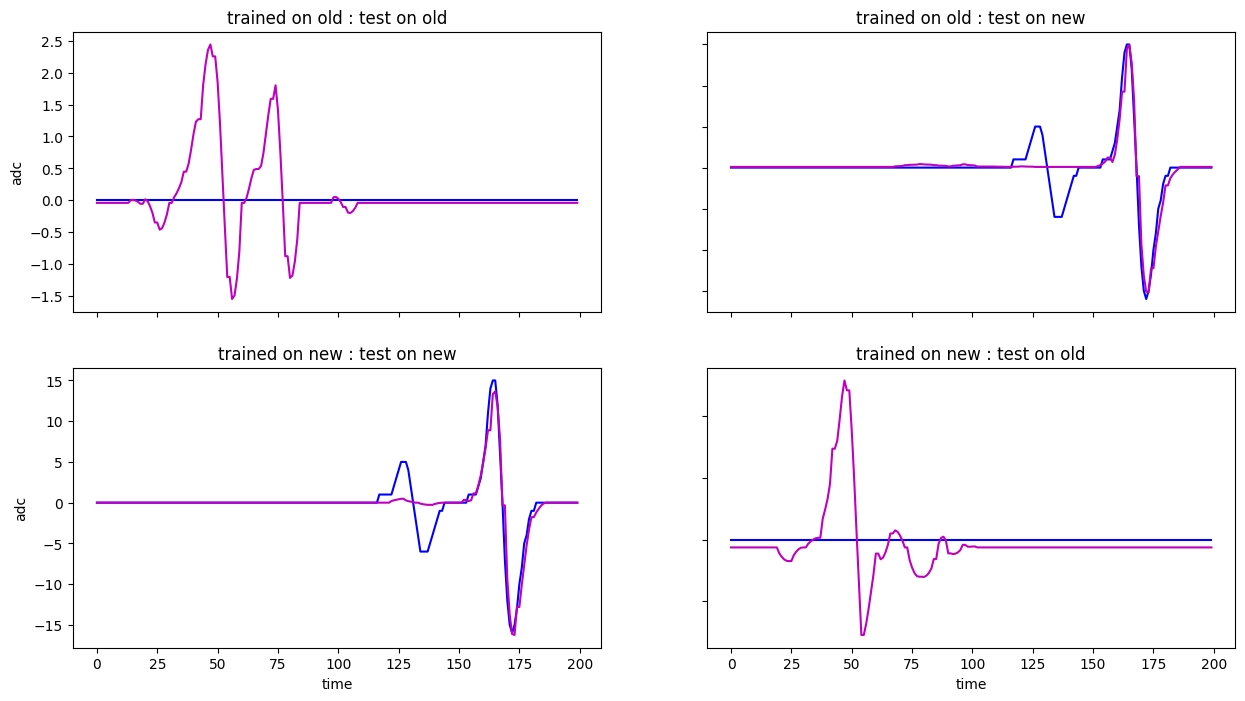

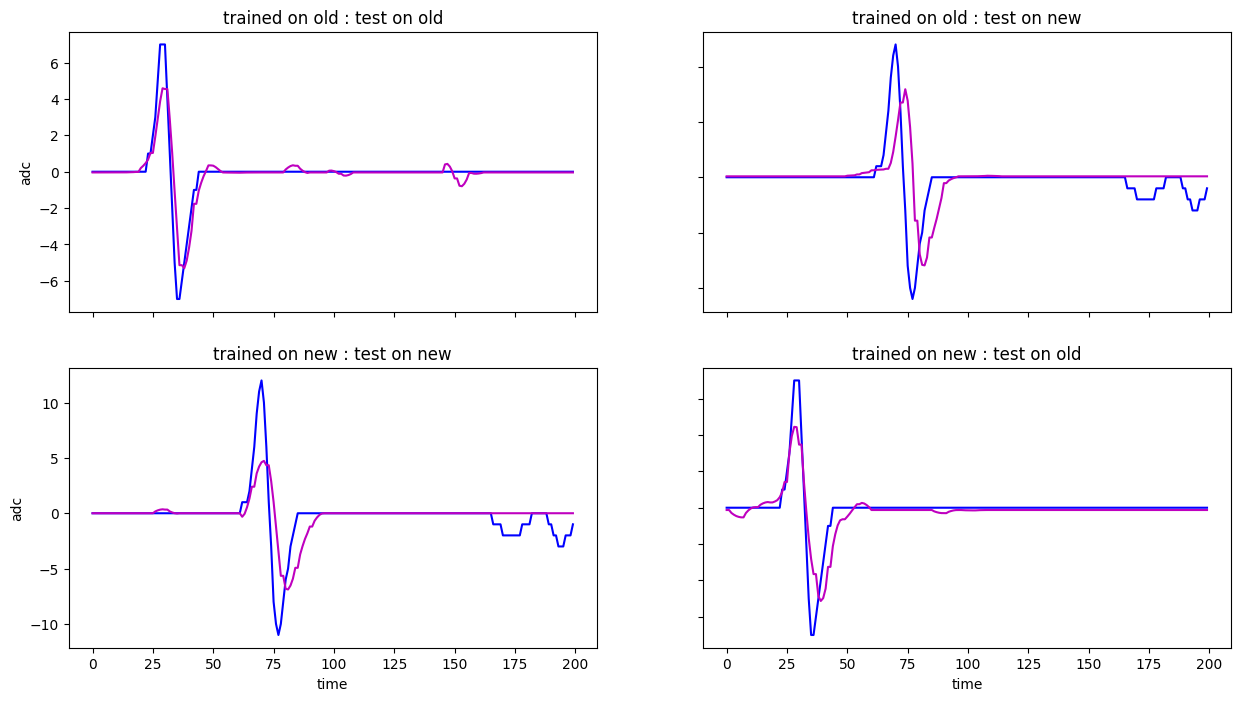

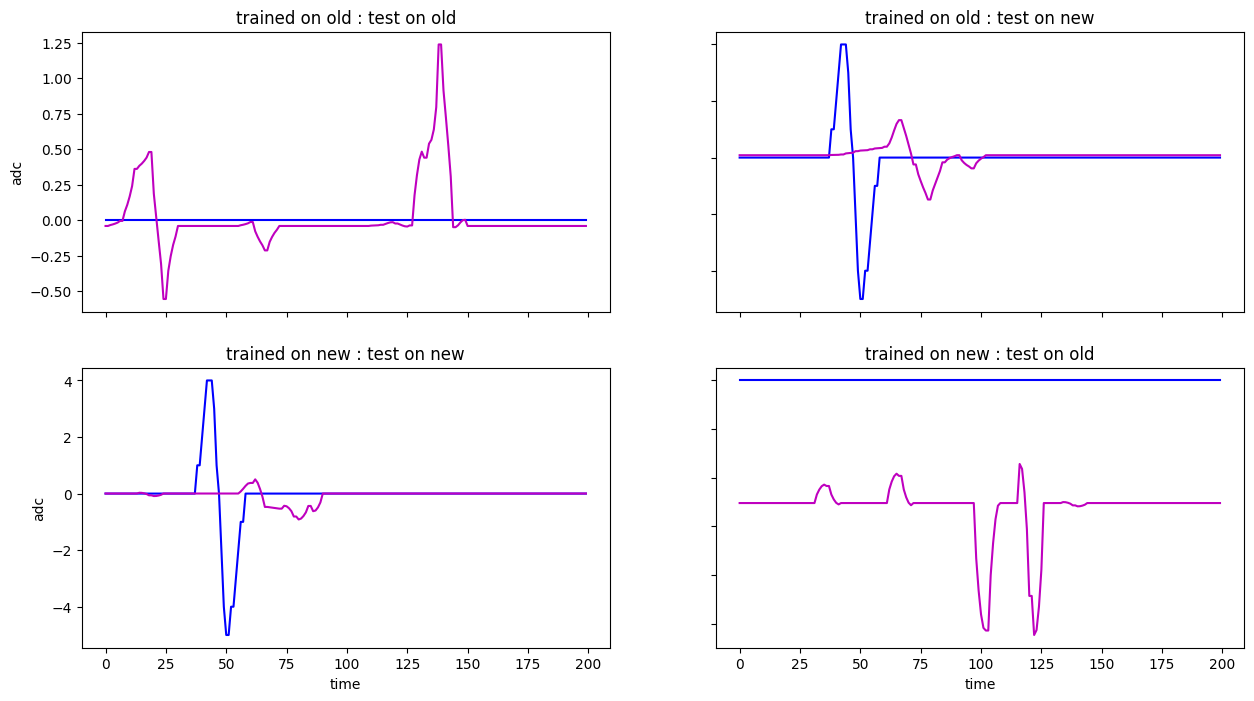

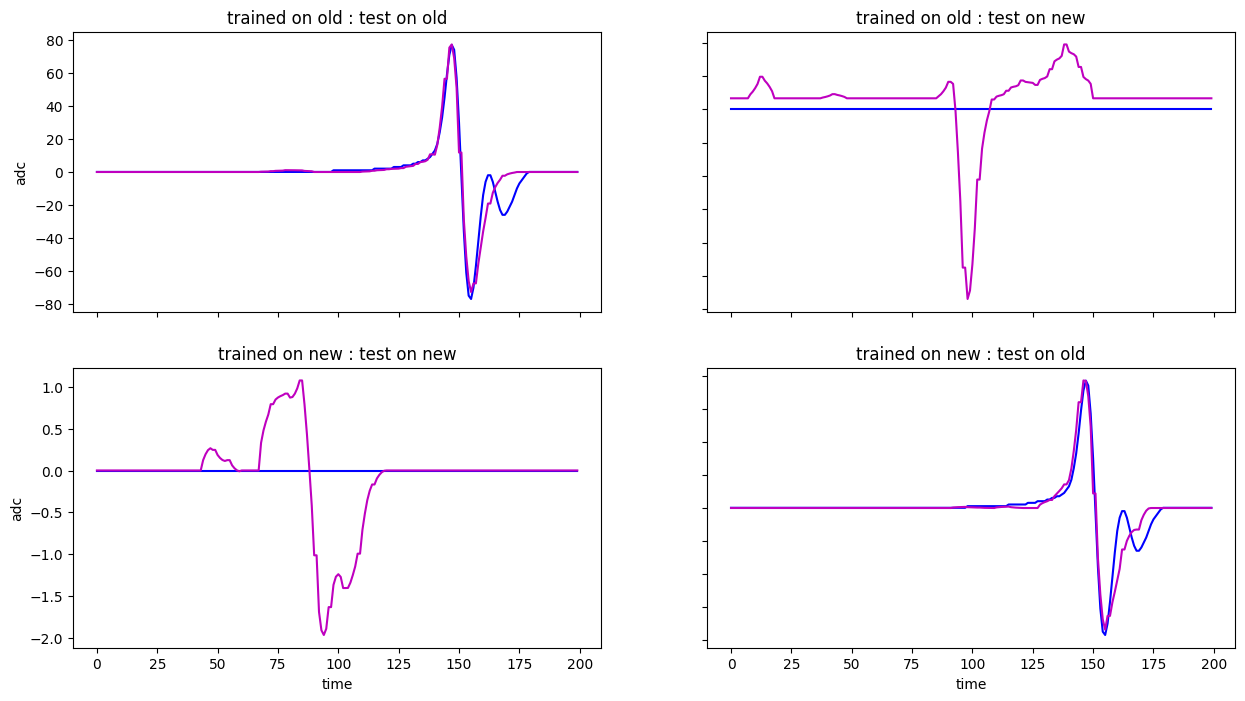

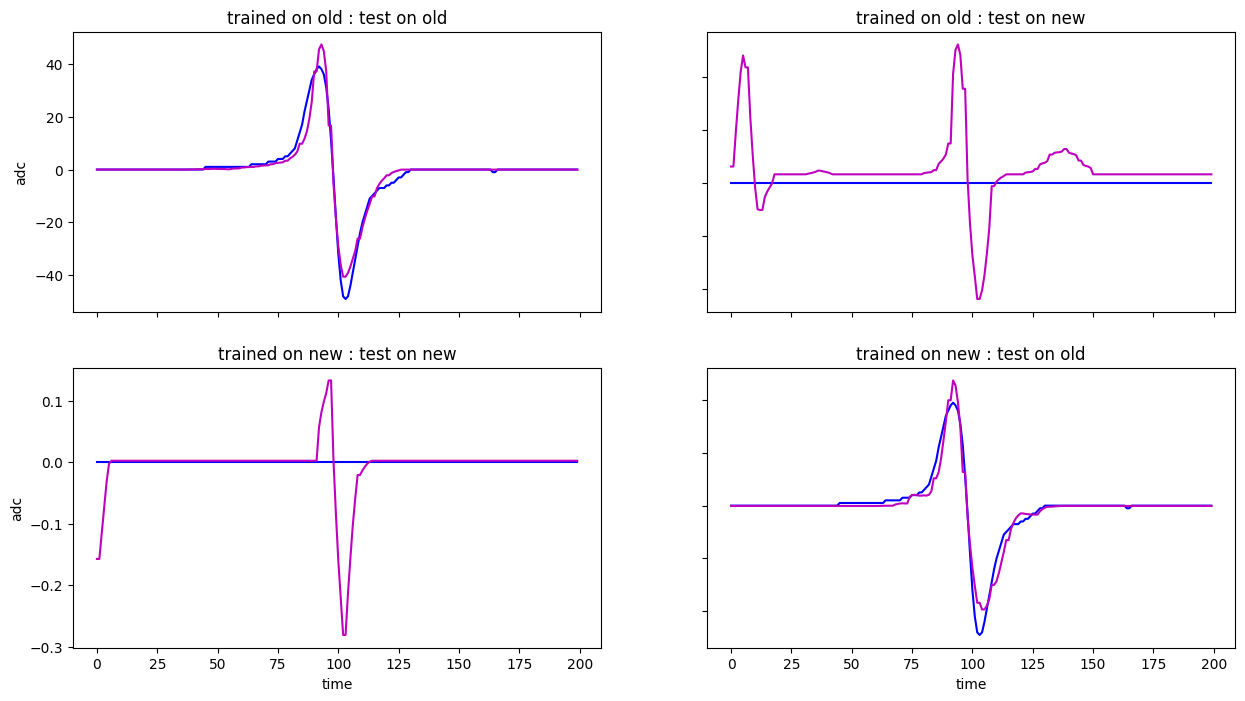

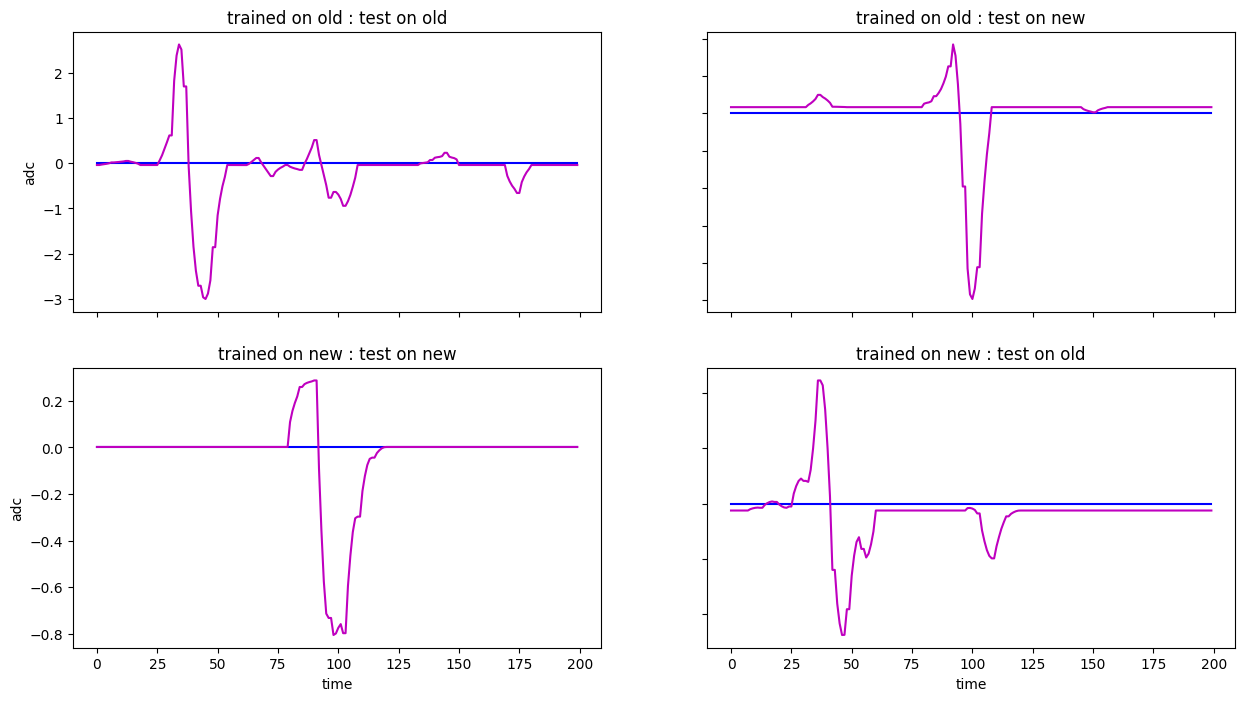

In [22]:
for i in range(10):
    fig, axs = plt.subplots(2, 2, figsize=(15,8))
    axs[0, 0].plot(y_testold_[i], color = 'blue')
    axs[0, 0].plot(pred_oo[i], color = 'm')
    axs[0, 0].set_title('trained on old : test on old')


    axs[0, 1].plot(y_testnew_[i], color = 'blue')
    axs[0, 1].plot(pred_on[i], color = 'm')
    axs[0, 1].set_title('trained on old : test on new')


    axs[1, 0].plot(y_testnew_[i], color = 'blue')
    axs[1, 0].plot(pred_nn[i], color = 'm')
    axs[1, 0].set_title('trained on new : test on new')


    axs[1, 1].plot(y_testold_[i], color = 'blue')
    axs[1, 1].plot(pred_no[i], color = 'm')
    axs[1, 1].set_title('trained on new : test on old')

    for ax in axs.flat:
        ax.set(xlabel='time', ylabel='adc')

    # Hide x labels and tick labels for top plots and y ticks for right plots.
    for ax in axs.flat:
        ax.label_outer()